# Summary
Here we do a validation of the 'simple' jaccard correlations by repeating some of the Spec2Vec metrics. Much of the code is directly copied from Florian's notebooks here https://github.com/iomega/spec2vec_gnps_data_analysis/blob/master/notebooks/

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import time

data_path = "/mnt/scratch/louwe015/Mass_differences/data/"

In [2]:
all_pos_version1 = False
if all_pos_version1:
    all_pos = "gnps_positive_ionmode_cleaned_by_matchms_and_lookups"
else:
    all_pos = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups"

print(all_pos)

ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups


In [3]:
if all_pos_version1:
    jacc_mat_file = None  # I didn't run this one
else:
    jacc_mat_file = "jaccard_matrix_allpos2_04-03-2021.npz"

jacc_mat_path = os.path.join(data_path, 'jaccard_matrices', jacc_mat_file)
print(jacc_mat_file, os.path.isfile(jacc_mat_path))

jaccard_matrix_allpos2_04-03-2021.npz True


## Load jaccard matrix and get MDs with correlations 0.1-0.5

In [41]:
low_cutoff = 0.1
high_cutoff = 0.5

In [6]:
jacc_mat_npz = np.load(jacc_mat_path, allow_pickle=True)

In [9]:
j_rows, j_cols, jacc_mat_sparse = [jacc_mat_npz[name] for name in jacc_mat_npz.files]
jacc_mat_sparse = jacc_mat_sparse.item()

In [27]:
jacc_mat_sparse

<61348x115913 sparse matrix of type '<class 'numpy.float64'>'
	with 384463253 stored elements in Compressed Sparse Row format>

In [34]:
maxes = jacc_mat_sparse.max(axis=1).toarray()

In [42]:
maxes_inds = [i for i, val in enumerate(maxes) if val[0] >= low_cutoff and val[0] <= high_cutoff]

In [45]:
maxes[:5], maxes_inds[:5]  # seems to have worked

(array([[0.13313639],
        [0.24642122],
        [0.1013701 ],
        [0.09151063],
        [0.08100498]]),
 [0, 1, 2, 5, 6])

In [54]:
# get MD names corresponding to these rows
chosen_mds = list(j_rows[maxes_inds])
j_rows[:10], chosen_mds[:5]

(array(['37.00', '37.01', '37.02', '37.03', '37.04', '37.05', '37.06',
        '37.07', '37.08', '37.09'], dtype='<U6'),
 ['37.00', '37.01', '37.02', '37.05', '37.06'])

In [53]:
# del(jacc_mat_sparse)
# del(jacc_mat_npz)

## Save/load chosen MDs

In [60]:
# save chosen MDs
out_indices = os.path.join(data_path, 'jaccard_matrices', jacc_mat_file.rpartition('.')[0]+"_chosen_MDs_0.1-0.5.txt")
print(out_indices)
with open(out_indices, 'w') as outf:
    for md in chosen_mds:
        outf.write(f'{md}\n')

/mnt/scratch/louwe015/Mass_differences/data/jaccard_matrices/jaccard_matrix_allpos2_04-03-2021_chosen_MDs_0.1-0.5.txt


In [9]:
out_indices = os.path.join(data_path, 'jaccard_matrices', jacc_mat_file.rpartition('.')[0]+"_chosen_MDs_0.1-0.5.txt")
print(out_indices, os.path.isfile(out_indices))
with open(out_indices, 'r') as inf:
    chosen_mds = [line.strip() for line in inf]
len(chosen_mds), chosen_mds[:5]

/mnt/scratch/louwe015/Mass_differences/data/jaccard_matrices/jaccard_matrix_allpos2_04-03-2021_chosen_MDs_0.1-0.5.txt True


(16595, ['37.00', '37.01', '37.02', '37.05', '37.06'])

## Load processed spectra for cosine, s2v, s2v+MDs
Spectra processed for s2v, s2v+MD, cosine scoring are loaded from notebook 1.

In [10]:
# load top30 file
top30_file = os.path.join(data_path, all_pos + "_top30_peaks.pickle")
if os.path.exists(top30_file):
    with open(top30_file, 'rb') as inf:
        spectrums_top30 = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")
# load processed file
processed_file = os.path.join(data_path, all_pos + "_processed.pickle")
if os.path.exists(processed_file):
    with open(processed_file, 'rb') as inf:
        spectrums_processed = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")
# load classical file
classical_file = os.path.join(data_path, all_pos + "_classical.pickle")
if os.path.exists(classical_file):
    with open(classical_file, 'rb') as inf:
        spectrums_classical = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

## Create test set of 1000 spectra whose inchikey exists in library >= 2 times

In [13]:
Inchikeys = []
for spec in spectrums_top30:
    Inchikeys.append(spec.get("inchikey"))
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:5]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
SRIGHEHXEGELQJ    338
IQGPMZRCLCCXAG    308
RWKUXQNLWDTSLO    235
dtype: int64

### Randomly select 1000 inchikeys that exist >=2 times in the dataset

In [19]:
min_copies_in_data = 2

suitable_inchikeys = pd.DataFrame(\
                                  inchikeys_pd.str[:14].value_counts()\
                                  [inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)

print(suitable_inchikeys.head(5))
print(suitable_inchikeys.tail(5))
print(f"Number of spectra with inchikeys that exist >= {min_copies_in_data} times:", suitable_inchikeys.shape[0])

       inchikey14  occurences
0  NEGQHKSYEYVFTD         432
1  SULIDBRAXVDKBU         426
2  SRIGHEHXEGELQJ         338
3  IQGPMZRCLCCXAG         308
4  RWKUXQNLWDTSLO         235
          inchikey14  occurences
7961  ABRULANJVVJLFI           2
7911  ABOPTWOWDLNBOE           2
8268  ABBPFXQJIWUCKF           2
8525  AAIIJIOWYALNCC           2
7631  AABZZWPMCAZHFC           2
Number of spectra with inchikeys that exist >= 2 times: 8686


In [20]:
num_spectra = 1000
np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[6403 4224  604 2955 1385 5566  554 4331 3132 2318 2718 6744  538 6040
 1578 5652  733 6853 7816 5686 3133 1432 4819 3047 7162]


array(['HUSISCNTLUEZCN', 'LKUNZSUKADSCME', 'SEOVTRFCIGRIMH',
       'JVHNBFFHWQQPLL', 'XPUOZJJNPJXFTD', 'DTDSAWVUFPGDMX',
       'DAWYIZBOUQIVNX', 'DQNFLBXNPGBCOU', 'OOGZWXIAHJKVAH',
       'DOVSRUBRIYLZCI', 'HBOMLICNUCNMMY', 'ZOFBAJKPGIIQFN',
       'PADQINQHPQKXNL', 'QGLZXHRNAYXIBU', 'FMEUWIKCSICJBO',
       'BEHLQMQPYDCEFC', 'LZJRNLRASBVRRX', 'YGWFCQYETHJKNX',
       'LQQBKDRWDYGCBI', 'ZZRGFLVYILOXAK', 'OLBLWNPOURNBCY',
       'SYWHXTATXSMDSB', 'IKYICRRUVNIHPP', 'XRBIHOLQAKITPP',
       'UQIDVGMGKVCWIS'], dtype=object)

### Inspect number of library spectra with same InChIKey as queries¶

In [21]:
inchikeys14_array = np.array([x[:14] for x in Inchikeys if x is not None])
number_of_copies = []
for inchikey in selected_inchikeys:
    number_of_copies.append(len(np.where(inchikeys14_array == inchikey)[0]))

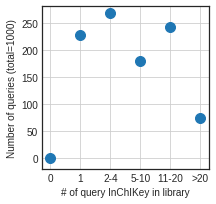

In [22]:
plt.figure(figsize=(3,3))
plt.style.use('seaborn-white')
bins = [0, 1.5, 2.5, 5.5, 11.5, 21.5, 101.5]
labels = ["0", "1", "2-4", "5-10", "11-20", ">20"]
a, b = np.histogram(number_of_copies, bins)
plt.scatter(labels, a, s=100)
plt.ylabel('Number of queries (total=1000)')
plt.xlabel('# of query InChIKey in library')
plt.ylim(-20)
plt.grid(True)
plt.show()
# plt.savefig("library_matching_scenario1_library_condition.svg")

### Randomly pick one spectra for each of the chosen inchikeys

In [23]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!
np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [24]:
selected_spectra[:10]

[15197, 27760, 65359, 74062, 107581, 20577, 88075, 91020, 95033, 95625]

In [26]:
# Show gnps IDs for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_top30[ID].get("spectrumid"),
         spectrums_top30[ID].get("inchikey")[:14])

CCMSLIB00000852865 HUSISCNTLUEZCN
CCMSLIB00005464770 LKUNZSUKADSCME
CCMSLIB00000218947 SEOVTRFCIGRIMH
CCMSLIB00005746855 JVHNBFFHWQQPLL
CCMSLIB00004714612 XPUOZJJNPJXFTD
CCMSLIB00001058664 DTDSAWVUFPGDMX
CCMSLIB00000569990 DAWYIZBOUQIVNX
CCMSLIB00004692982 DQNFLBXNPGBCOU
CCMSLIB00004698130 OOGZWXIAHJKVAH
CCMSLIB00004698872 DOVSRUBRIYLZCI


## Train new model on AllPositive (2) without selected spectra
Two new models, one on 'normal' Spec2Vec and one with selected MDs added

In [27]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_library_processed = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_processed) if i not in selected_spectra]
documents_library_classical = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_classical) if i not in selected_spectra]
len(documents_library_processed), len(spectrums_processed)  # 1000 should be removed

(114344, 115344)

In [30]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(data_path, "trained_models")
model_file = os.path.join(path_models, all_pos+"_spec2vec_librarymatching_24-03.model")

iterations = [1, 3, 5, 10, 15, 20]
# Train model with default parameters
model = train_new_word2vec_model(documents_library_processed, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 6120857.5
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_24-03_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4557735.5
  Epoch 3 of 20.Change in loss after epoch 3: 4054406.0
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_24-03_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3615177.0
  Epoch 5 of 20.Change in loss after epoch 5: 3170450.0
Saving model with name: /mnt/scratch/louwe015/Mass_differences/data/trained_models/ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_librarymatching_24-03_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 2994854.0
  Epoch 7 of 20.Change in loss after epoch 7: 2939582.0
  Epoch 8 of 20.Change in loss after epoch 8: 2809522.0
  E